In [1]:
# Import necessary packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
df = pd.read_csv('FB.csv')

In [3]:
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200


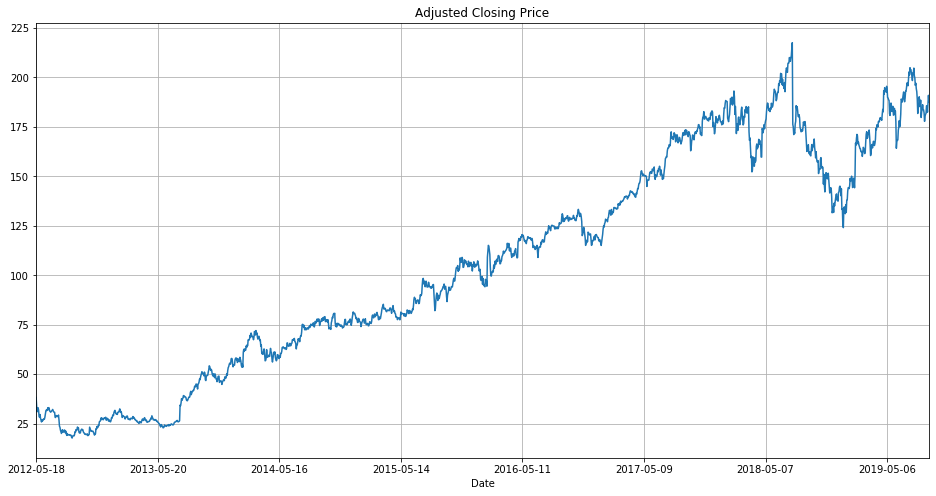

In [4]:
df['Adj Close'].plot(label='FB', figsize=(16,8), title='Adjusted Closing Price', grid=True)

In [5]:
window_size = 32 # Allow us to look at 32 days into the past
# Prepare the data so that we have 32 day windows and predict what the next day should be

# Get indices of access for the data
num_samples = len(df) - window_size
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)

In [6]:
data = df['Adj Close'].values[indices] # Create the 2D matrix of training samples

In [7]:
X = data[:,:-1] # Each row represents 32 days in the past
y = data[:,-1] # Each output value represents the 33rd day

In [8]:
# Train and test split
split_fraction = 0.8
ind_split = int(split_fraction * num_samples)
X_train = X[:ind_split]
y_train = y[:ind_split]
X_test = X[ind_split:]
y_test = y[ind_split:]

In [9]:
# Train
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Infer
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_ridge = ridge_model.predict(X_test)

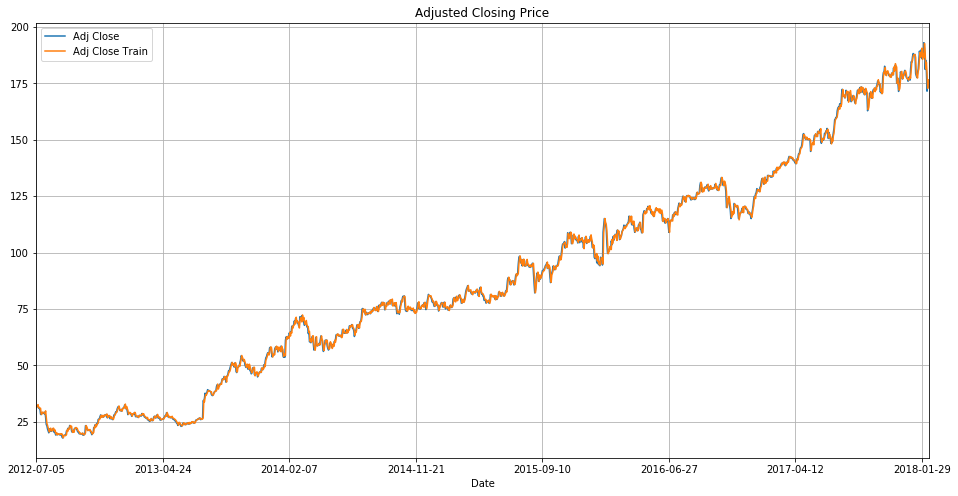

In [10]:
# Plot what it looks like for the training data
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_ridge['Adj Close Train'] = y_pred_train_ridge[:-window_size]
df_ridge.plot(label='FB', figsize=(16,8), title='Adjusted Closing Price', grid=True)

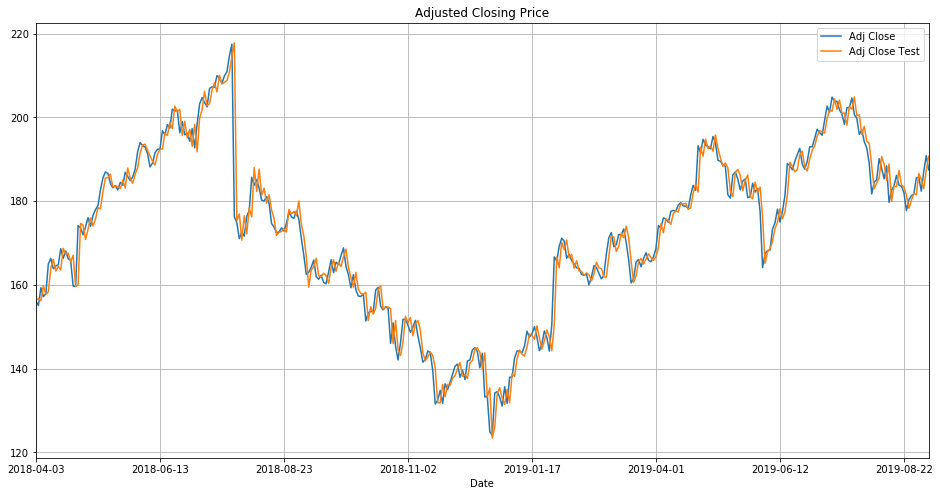

In [11]:
# Same for the test
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_ridge['Adj Close Test'] = y_pred_ridge
df_ridge.plot(label='FB', figsize=(16,8), title='Adjusted Closing Price', grid=True)

In [12]:
# Model #2 - Gradient Boosting Trees
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Infer
y_pred_train_gb = gb_model.predict(X_train)
y_pred_gb = gb_model.predict(X_test)

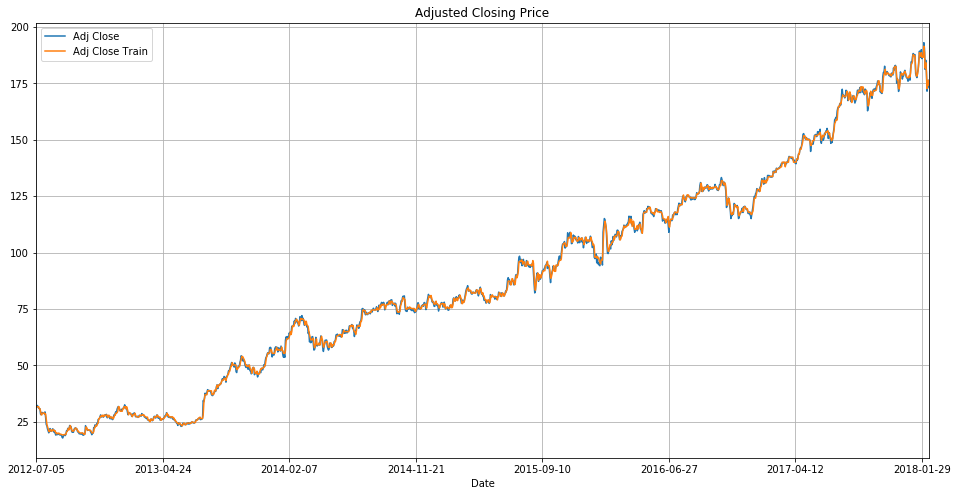

In [13]:
# Plot what it looks like for the training data
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_gb['Adj Close Train'] = y_pred_train_gb[:-window_size]
df_gb.plot(label='FB', figsize=(16,8), title='Adjusted Closing Price', grid=True)

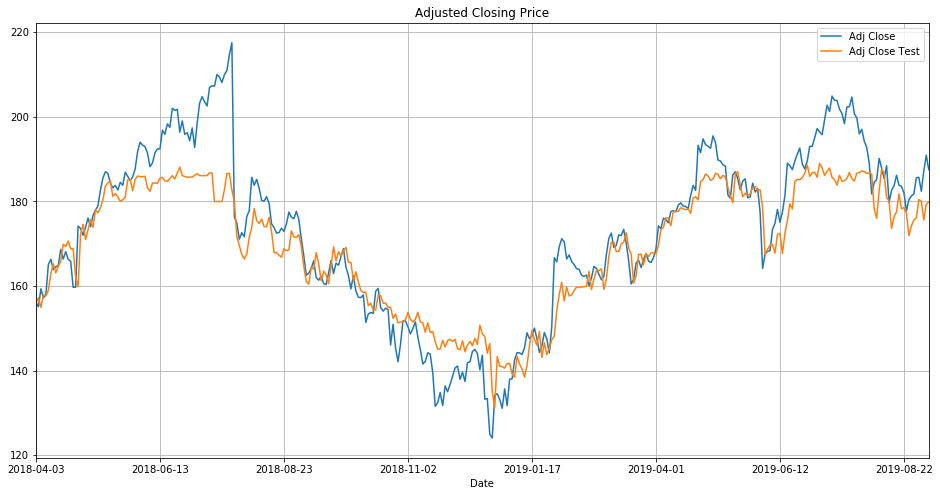

In [14]:
# Same for the test
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_gb['Adj Close Test'] = y_pred_gb
df_gb.plot(label='FB', figsize=(16,8), title='Adjusted Closing Price', grid=True)

In [15]:
# Model #3 - Using RNNs
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])

keras_model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 32, 128)           768       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 128)           82048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)             

In [16]:
# First figure out the right learning rate
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = SGD(lr=1e-8, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
# Scale the data due to LSTM units
scaler = MinMaxScaler(feature_range=(-1, 1))
data_transform = scaler.fit_transform(df['Adj Close'].values[:,None])
data_transform = data_transform[indices]
X2 = data_transform[:,:-1]
y2 = data_transform[:,-1]
X_train_reshape = X2[:ind_split]
y_train_reshape = y2[:ind_split]
X_test_reshape = X2[ind_split:]
y_test_reshape = y2[ind_split:]

In [17]:
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, callbacks=[lr_schedule], validation_data=(X_test_reshape, y_test_reshape))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1444 samples, validate on 361 samples
Epoch 1/250
1444/1444 [==============================] - 7s 5ms/step - loss: 0.1535 - mean_absolute_error: 0.4680 - val_loss: 0.1754 - val_mean_absolute_error: 0.5574
Epoch 2/250
1444/1444 [==============================] - 4s 3ms/step - loss: 0.1535 - mean_absolute_error: 0.4680 - val_loss: 0.1754 - val_mean_absolute_error: 0.5574
Epoch 3/250
1444/1444 [==============================] - 4s 3ms/step - loss: 0.1535 - mean_absolute_error: 0.4680 - val_loss: 0.1754 - val_mean_absolute_error: 0.5574
Epoch 4/250
1444/1444 [==============================] - 4s 3ms/step - loss: 0.1535 - mean_absolute_error: 0.4680 - val_loss: 0.1754 - val_mean_absolute_error: 0.5574
Epoch 5/250
1444/1444 [==============================] - 4s 3ms/step - loss: 0.1535 - mean_absolute_error: 0.4680 - val_loss: 0.1754 - val_mean_absolute_error: 0.5574
Epoch 6/250
1444/1444 

1444/1444 [==============================] - 4s 3ms/step - loss: 0.1527 - mean_absolute_error: 0.4668 - val_loss: 0.1755 - val_mean_absolute_error: 0.5578
Epoch 46/250
1444/1444 [==============================] - 4s 3ms/step - loss: 0.1526 - mean_absolute_error: 0.4666 - val_loss: 0.1756 - val_mean_absolute_error: 0.5579
Epoch 47/250
1444/1444 [==============================] - 4s 3ms/step - loss: 0.1525 - mean_absolute_error: 0.4664 - val_loss: 0.1756 - val_mean_absolute_error: 0.5579
Epoch 48/250
1444/1444 [==============================] - 4s 3ms/step - loss: 0.1523 - mean_absolute_error: 0.4663 - val_loss: 0.1756 - val_mean_absolute_error: 0.5580
Epoch 49/250
1444/1444 [==============================] - 4s 3ms/step - loss: 0.1522 - mean_absolute_error: 0.4660 - val_loss: 0.1756 - val_mean_absolute_error: 0.5581
Epoch 50/250
1444/1444 [==============================] - 4s 3ms/step - loss: 0.1521 - mean_absolute_error: 0.4658 - val_loss: 0.1757 - val_mean_absolute_error: 0.5581
Epoch

Epoch 94/250
1444/1444 [==============================] - 4s 2ms/step - loss: 0.0484 - mean_absolute_error: 0.2606 - val_loss: 0.1398 - val_mean_absolute_error: 0.5089
Epoch 95/250
1444/1444 [==============================] - 4s 2ms/step - loss: 0.0430 - mean_absolute_error: 0.2443 - val_loss: 0.1286 - val_mean_absolute_error: 0.4879
Epoch 96/250
1444/1444 [==============================] - 4s 3ms/step - loss: 0.0377 - mean_absolute_error: 0.2271 - val_loss: 0.1158 - val_mean_absolute_error: 0.4625
Epoch 97/250
1444/1444 [==============================] - 4s 3ms/step - loss: 0.0324 - mean_absolute_error: 0.2088 - val_loss: 0.1014 - val_mean_absolute_error: 0.4319
Epoch 98/250
1444/1444 [==============================] - 4s 3ms/step - loss: 0.0272 - mean_absolute_error: 0.1901 - val_loss: 0.0860 - val_mean_absolute_error: 0.3961
Epoch 99/250
1444/1444 [==============================] - 4s 3ms/step - loss: 0.0222 - mean_absolute_error: 0.1711 - val_loss: 0.0700 - val_mean_absolute_error:

1444/1444 [==============================] - 4s 2ms/step - loss: 9.5063e-04 - mean_absolute_error: 0.0325 - val_loss: 0.0047 - val_mean_absolute_error: 0.0806
Epoch 143/250
1444/1444 [==============================] - 4s 3ms/step - loss: 9.7920e-04 - mean_absolute_error: 0.0335 - val_loss: 0.0046 - val_mean_absolute_error: 0.0796
Epoch 144/250
1444/1444 [==============================] - 4s 3ms/step - loss: 9.8156e-04 - mean_absolute_error: 0.0334 - val_loss: 0.0047 - val_mean_absolute_error: 0.0799
Epoch 145/250
1444/1444 [==============================] - 4s 3ms/step - loss: 9.4757e-04 - mean_absolute_error: 0.0324 - val_loss: 0.0047 - val_mean_absolute_error: 0.0797
Epoch 146/250
1444/1444 [==============================] - 4s 3ms/step - loss: 0.0011 - mean_absolute_error: 0.0345 - val_loss: 0.0048 - val_mean_absolute_error: 0.0802
Epoch 147/250
1444/1444 [==============================] - 4s 2ms/step - loss: 0.0014 - mean_absolute_error: 0.0421 - val_loss: 0.0046 - val_mean_absolut

1444/1444 [==============================] - 4s 3ms/step - loss: 1602.6135 - mean_absolute_error: 1603.1136 - val_loss: 2747.0235 - val_mean_absolute_error: 2747.5237
Epoch 190/250
1444/1444 [==============================] - 4s 3ms/step - loss: 3598.0424 - mean_absolute_error: 3598.5427 - val_loss: 89.6295 - val_mean_absolute_error: 90.1295
Epoch 191/250
1444/1444 [==============================] - 5s 3ms/step - loss: 1520.0387 - mean_absolute_error: 1520.5390 - val_loss: 1767.2867 - val_mean_absolute_error: 1767.7869
Epoch 192/250
1444/1444 [==============================] - 4s 3ms/step - loss: 2400.2264 - mean_absolute_error: 2400.7264 - val_loss: 1001.1111 - val_mean_absolute_error: 1001.6113
Epoch 193/250
1444/1444 [==============================] - 4s 3ms/step - loss: 981.9387 - mean_absolute_error: 982.4388 - val_loss: 2506.7662 - val_mean_absolute_error: 2507.2665
Epoch 194/250
1444/1444 [==============================] - 4s 3ms/step - loss: 1594.7239 - mean_absolute_error: 159

Epoch 234/250
1444/1444 [==============================] - 4s 2ms/step - loss: 270570.3718 - mean_absolute_error: 270570.8489 - val_loss: 125347.5760 - val_mean_absolute_error: 125348.0770
Epoch 235/250
1444/1444 [==============================] - 4s 3ms/step - loss: 311628.5823 - mean_absolute_error: 311629.1051 - val_loss: 183989.6332 - val_mean_absolute_error: 183990.1886
Epoch 236/250
1444/1444 [==============================] - 4s 2ms/step - loss: 348107.4903 - mean_absolute_error: 348107.9567 - val_loss: 320830.4386 - val_mean_absolute_error: 320830.9920
Epoch 237/250
1444/1444 [==============================] - 4s 3ms/step - loss: 383941.3447 - mean_absolute_error: 383941.7945 - val_loss: 512123.8136 - val_mean_absolute_error: 512124.1977
Epoch 238/250
1444/1444 [==============================] - 5s 3ms/step - loss: 221845.3523 - mean_absolute_error: 221845.8151 - val_loss: 1356.0583 - val_mean_absolute_error: 1356.5579
Epoch 239/250
1444/1444 [==============================] - 

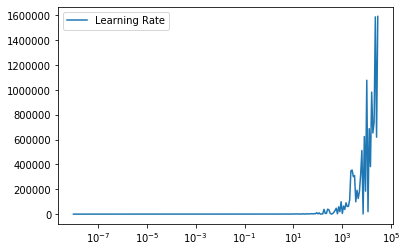

In [18]:
plt.semilogx(history.history['lr'], history.history['val_loss'])
plt.legend(['Learning Rate', 'Validation Loss'])

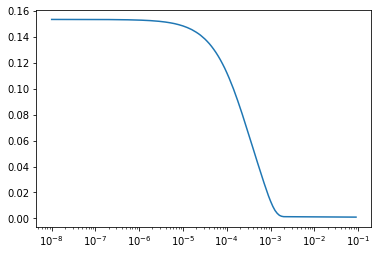

In [19]:
plt.semilogx(history.history['lr'][:140], history.history['loss'][:140])

In [20]:
# Observing the above graph, 0.1 seems to be the best learning rate
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])


optimizer = SGD(lr=0.1, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, validation_data=(X_test_reshape, y_test_reshape))

Train on 1444 samples, validate on 361 samples
Epoch 1/250
1444/1444 [==============================] - 7s 5ms/step - loss: 0.0631 - mean_absolute_error: 0.2839 - val_loss: 0.1231 - val_mean_absolute_error: 0.4870
Epoch 2/250
1444/1444 [==============================] - 4s 3ms/step - loss: 0.0243 - mean_absolute_error: 0.1805 - val_loss: 0.0764 - val_mean_absolute_error: 0.3708
Epoch 3/250
1444/1444 [==============================] - 4s 3ms/step - loss: 0.0150 - mean_absolute_error: 0.1360 - val_loss: 0.0287 - val_mean_absolute_error: 0.2196
Epoch 4/250
1444/1444 [==============================] - 4s 3ms/step - loss: 0.0069 - mean_absolute_error: 0.0944 - val_loss: 0.0195 - val_mean_absolute_error: 0.1709
Epoch 5/250
1444/1444 [==============================] - 4s 3ms/step - loss: 0.0051 - mean_absolute_error: 0.0842 - val_loss: 0.0079 - val_mean_absolute_error: 0.1034
Epoch 6/250
1444/1444 [==============================] - 4s 3ms/step - loss: 0.0032 - mean_absolute_error: 0.0652 - va

Epoch 49/250
1444/1444 [==============================] - 4s 2ms/step - loss: 7.3331e-04 - mean_absolute_error: 0.0277 - val_loss: 0.0037 - val_mean_absolute_error: 0.0686
Epoch 50/250
1444/1444 [==============================] - 4s 3ms/step - loss: 7.1498e-04 - mean_absolute_error: 0.0271 - val_loss: 0.0040 - val_mean_absolute_error: 0.0717
Epoch 51/250
1444/1444 [==============================] - 4s 3ms/step - loss: 7.2933e-04 - mean_absolute_error: 0.0273 - val_loss: 0.0037 - val_mean_absolute_error: 0.0693
Epoch 52/250
1444/1444 [==============================] - 4s 2ms/step - loss: 7.4677e-04 - mean_absolute_error: 0.0281 - val_loss: 0.0036 - val_mean_absolute_error: 0.0685
Epoch 53/250
1444/1444 [==============================] - 4s 2ms/step - loss: 7.1471e-04 - mean_absolute_error: 0.0270 - val_loss: 0.0037 - val_mean_absolute_error: 0.0694
Epoch 54/250
1444/1444 [==============================] - 4s 2ms/step - loss: 7.0029e-04 - mean_absolute_error: 0.0267 - val_loss: 0.0037 - 

1444/1444 [==============================] - 4s 3ms/step - loss: 6.6104e-04 - mean_absolute_error: 0.0259 - val_loss: 0.0034 - val_mean_absolute_error: 0.0649
Epoch 97/250
1444/1444 [==============================] - 4s 3ms/step - loss: 6.8294e-04 - mean_absolute_error: 0.0268 - val_loss: 0.0032 - val_mean_absolute_error: 0.0630
Epoch 98/250
1444/1444 [==============================] - 4s 3ms/step - loss: 6.4583e-04 - mean_absolute_error: 0.0256 - val_loss: 0.0033 - val_mean_absolute_error: 0.0635
Epoch 99/250
1444/1444 [==============================] - 4s 3ms/step - loss: 6.3072e-04 - mean_absolute_error: 0.0253 - val_loss: 0.0033 - val_mean_absolute_error: 0.0636
Epoch 100/250
1444/1444 [==============================] - 4s 2ms/step - loss: 6.7099e-04 - mean_absolute_error: 0.0265 - val_loss: 0.0032 - val_mean_absolute_error: 0.0629
Epoch 101/250
1444/1444 [==============================] - 4s 3ms/step - loss: 6.8641e-04 - mean_absolute_error: 0.0267 - val_loss: 0.0033 - val_mean_ab

1444/1444 [==============================] - 4s 2ms/step - loss: 5.8051e-04 - mean_absolute_error: 0.0241 - val_loss: 0.0029 - val_mean_absolute_error: 0.0583
Epoch 144/250
1444/1444 [==============================] - 4s 2ms/step - loss: 5.8632e-04 - mean_absolute_error: 0.0241 - val_loss: 0.0030 - val_mean_absolute_error: 0.0600
Epoch 145/250
1444/1444 [==============================] - 4s 2ms/step - loss: 5.6814e-04 - mean_absolute_error: 0.0234 - val_loss: 0.0030 - val_mean_absolute_error: 0.0596
Epoch 146/250
1444/1444 [==============================] - 4s 3ms/step - loss: 5.6604e-04 - mean_absolute_error: 0.0236 - val_loss: 0.0030 - val_mean_absolute_error: 0.0594
Epoch 147/250
1444/1444 [==============================] - 4s 2ms/step - loss: 5.6466e-04 - mean_absolute_error: 0.0235 - val_loss: 0.0030 - val_mean_absolute_error: 0.0602
Epoch 148/250
1444/1444 [==============================] - 4s 3ms/step - loss: 5.7841e-04 - mean_absolute_error: 0.0241 - val_loss: 0.0029 - val_mean

1444/1444 [==============================] - 4s 2ms/step - loss: 5.3441e-04 - mean_absolute_error: 0.0228 - val_loss: 0.0028 - val_mean_absolute_error: 0.0576
Epoch 191/250
1444/1444 [==============================] - 4s 2ms/step - loss: 5.4198e-04 - mean_absolute_error: 0.0230 - val_loss: 0.0028 - val_mean_absolute_error: 0.0584
Epoch 192/250
1444/1444 [==============================] - 4s 2ms/step - loss: 5.3245e-04 - mean_absolute_error: 0.0229 - val_loss: 0.0027 - val_mean_absolute_error: 0.0564
Epoch 193/250
1444/1444 [==============================] - 4s 3ms/step - loss: 5.3714e-04 - mean_absolute_error: 0.0231 - val_loss: 0.0027 - val_mean_absolute_error: 0.0550
Epoch 194/250
1444/1444 [==============================] - 4s 3ms/step - loss: 5.2290e-04 - mean_absolute_error: 0.0227 - val_loss: 0.0028 - val_mean_absolute_error: 0.0574
Epoch 195/250
1444/1444 [==============================] - 4s 2ms/step - loss: 5.2159e-04 - mean_absolute_error: 0.0229 - val_loss: 0.0026 - val_mean

1444/1444 [==============================] - 4s 3ms/step - loss: 4.9660e-04 - mean_absolute_error: 0.0222 - val_loss: 0.0025 - val_mean_absolute_error: 0.0520
Epoch 238/250
1444/1444 [==============================] - 4s 3ms/step - loss: 4.8971e-04 - mean_absolute_error: 0.0217 - val_loss: 0.0026 - val_mean_absolute_error: 0.0564
Epoch 239/250
1444/1444 [==============================] - 4s 3ms/step - loss: 4.8462e-04 - mean_absolute_error: 0.0217 - val_loss: 0.0025 - val_mean_absolute_error: 0.0526
Epoch 240/250
1444/1444 [==============================] - 4s 3ms/step - loss: 4.7636e-04 - mean_absolute_error: 0.0215 - val_loss: 0.0025 - val_mean_absolute_error: 0.0542
Epoch 241/250
1444/1444 [==============================] - 4s 3ms/step - loss: 4.8262e-04 - mean_absolute_error: 0.0218 - val_loss: 0.0024 - val_mean_absolute_error: 0.0524
Epoch 242/250
1444/1444 [==============================] - 4s 3ms/step - loss: 4.9581e-04 - mean_absolute_error: 0.0220 - val_loss: 0.0025 - val_mean

In [21]:
y_pred_train_keras = scaler.inverse_transform(keras_model.predict(X_train_reshape, batch_size=256))
y_pred_keras = scaler.inverse_transform(keras_model.predict(X_test_reshape, batch_size=256))

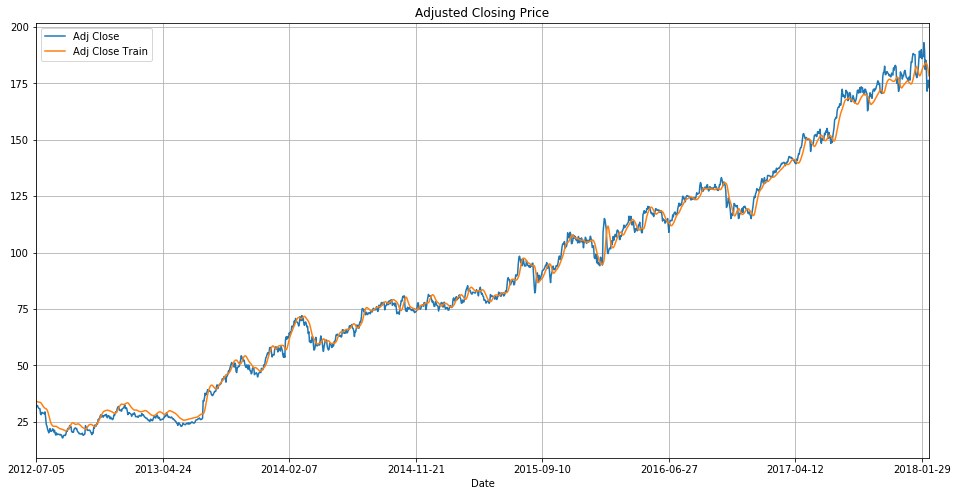

In [22]:
# Plot what it looks like for the training data
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_keras['Adj Close Train'] = y_pred_train_keras[:-window_size]
df_keras.plot(label='FB', figsize=(16,8), title='Adjusted Closing Price', grid=True)

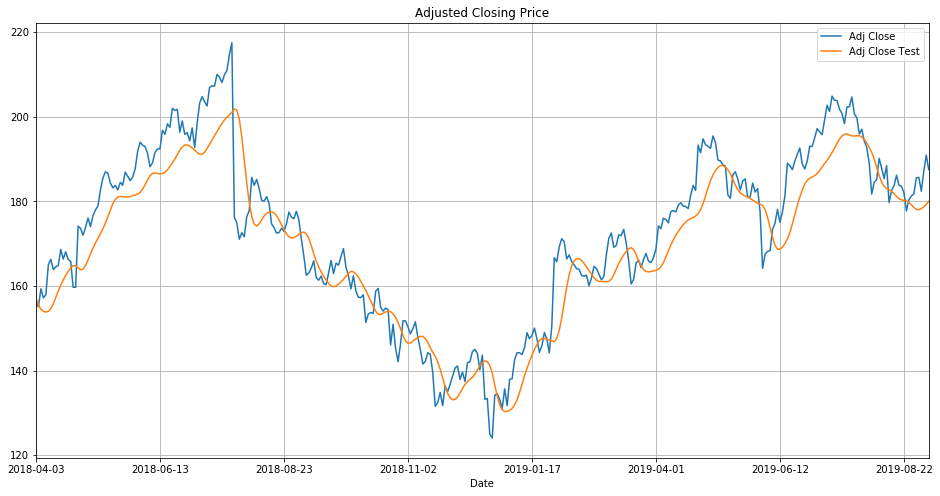

In [23]:
# Same for the test
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_keras['Adj Close Test'] = y_pred_keras
df_keras.plot(label='FB', figsize=(16,8), title='Adjusted Closing Price', grid=True)

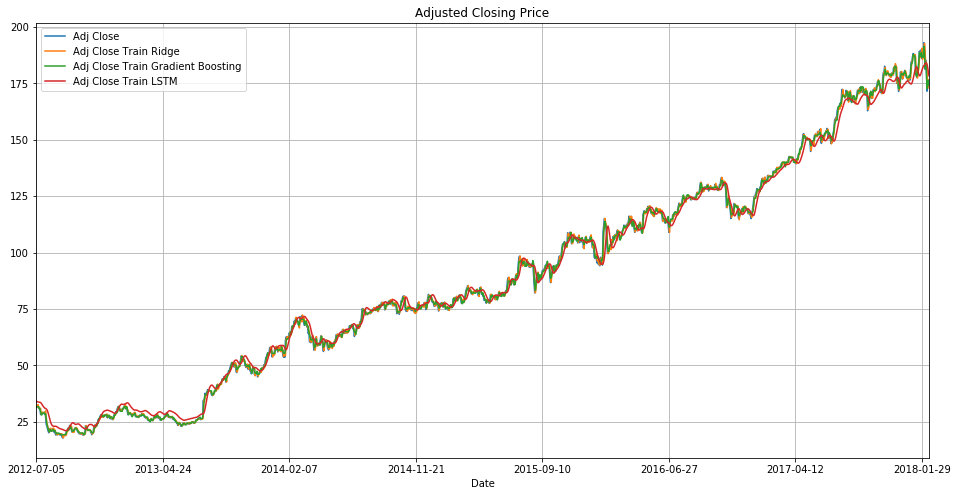

In [24]:
df_train = df.copy()
df_train.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_train = df_train.iloc[window_size:ind_split] # Past 32 days we don't know yet
# Add in all of our methods
df_train['Adj Close Train Ridge'] = y_pred_train_ridge[:-window_size]
df_train['Adj Close Train Gradient Boosting'] = y_pred_train_gb[:-window_size]
df_train['Adj Close Train LSTM'] = y_pred_train_keras[:-window_size]
# Plot the data now
df_train.plot(label='FB', figsize=(16,8), title='Adjusted Closing Price', grid=True)

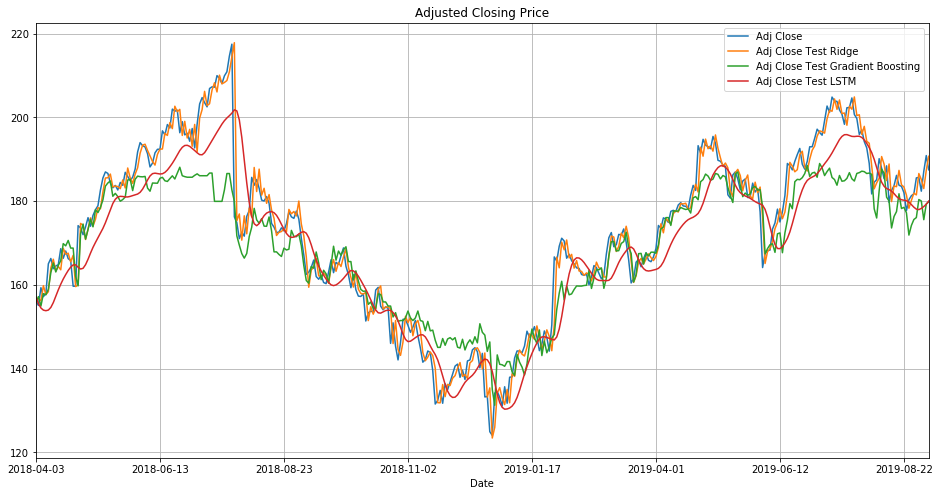

In [25]:
df_test = df.copy()
df_test.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_test = df_test.iloc[ind_split+window_size:] # Past 32 days we don't know yet
# Add in all of our methods
df_test['Adj Close Test Ridge'] = y_pred_ridge
df_test['Adj Close Test Gradient Boosting'] = y_pred_gb
df_test['Adj Close Test LSTM'] = y_pred_keras
# Plot the data now
df_test.plot(label='FB', figsize=(16,8), title='Adjusted Closing Price', grid=True)